In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import string, re, emoji
import itertools
from collections import Counter

# Libraries for text preprocessing.
! pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy

from scipy.stats import kstest

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches


plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [2]:
model_name='bert-large-uncased' 
learning_rate=5e-6
num_epochs = 22
max_length = 512
batch_size = 36


In [3]:
df=pd.read_parquet('./input/movie-genre-prediction/train-00000-of-00001-b943ea66e0040b18.parquet')
df.head()

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action


In [4]:
df2=pd.read_parquet('./input/movie-genre-prediction/train-00000-of-00001-b943ea66e0040b18.parquet')
df2.head()

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action


In [5]:
# Step 1: Combine movie_name and synopsis into "Hit Sentence" column
df['Hit Sentence'] = df['movie_name'] + " - " + df['synopsis']

# Step 2: Check the existing values in the "genre" column and create genre_dict
genre_dict = {genre: idx for idx, genre in enumerate(df['genre'].unique())}

# Step 3: Convert genre column values to numbers using the updated dictionary
df['target'] = df['genre'].map(genre_dict)

# Display the updated DataFrame
df=df[['Hit Sentence','target']]

In [6]:
df2['Hit Sentence'] = df2['movie_name'] + " - " + df2['synopsis']
df2=df2[['Hit Sentence']]

# Helper functions to preprocess text

In [7]:
def lowercase(text: str) -> str:
    """Converts letters in given text to lowercase.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Lowercase text.

    """
    preprocessedText = str.lower(text)
    return  preprocessedText

def remove_hashtags(text: str) -> str:
    """Removes hashtags from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no hashtags.

    """
    preprocessedText = re.sub('#[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_mentions(text: str) -> str:
    """Removes mentions from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no mentions.

    """
    preprocessedText = re.sub('@[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_punctuation(text: str) -> str:
    """Removes non text characters from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no non tex characters.

    """
    preprocessedText = text.translate(str.maketrans('', '', string.punctuation))

    return preprocessedText

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    """_summary_

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_stopwords(text: str) -> str:
    """Removes stopwords.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no stopwords.

    """
    wordList = text.split() 
    preprecessedWordList = []

    stopWords = stopwords.words('english')
    stopWords += ['rt', 'qt', '’']

    for word in wordList:
        if word not in stopWords:
            preprecessedWordList.append(word)

    preprocessedText = ' '.join(preprecessedWordList)

    return preprocessedText

In [8]:
# Remove blank rows if any.
df['Hit Sentence'].dropna(inplace=True)

# Applying helper functions

df['text_clean'] = df['Hit Sentence'].apply(lambda x: lowercase(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_hashtags(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_mentions(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punctuation(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))
df['tokenized'] = [word_tokenize(entry) for entry in df['text_clean']]
df['text_clean']= [str(word_tokenize(entry)) for entry in df['text_clean']]

df['text_str'] = df['text_clean'].apply(lambda x: ' '.join(eval(x)))

In [9]:
# Remove blank rows if any.
df2['Hit Sentence'].dropna(inplace=True)
# Applying helper functions
df2['text_clean'] = df2['Hit Sentence'].apply(lambda x: lowercase(x))
df2['text_clean'] = df2['text_clean'].apply(lambda x: remove_hashtags(x))
df2['text_clean'] = df2['text_clean'].apply(lambda x: remove_mentions(x))
df2['text_clean'] = df2['text_clean'].apply(lambda x: remove_emoji(x))
df2['text_clean'] = df2['text_clean'].apply(lambda x: remove_html(x))
df2['text_clean'] = df2['text_clean'].apply(lambda x: remove_punctuation(x))
df2['text_clean'] = df2['text_clean'].apply(lambda x: remove_stopwords(x))
df2['tokenized'] = [word_tokenize(entry) for entry in df2['text_clean']]
df2['text_clean']= [str(word_tokenize(entry)) for entry in df2['text_clean']]
df2['text_str'] = df2['text_clean'].apply(lambda x: ' '.join(eval(x)))
df2

,Hit Sentence,text_clean,tokenized,text_str
0,Super Me - A young scriptwriter starts bringin...,"['super', 'young', 'scriptwriter', 'starts', '...","[super, young, scriptwriter, starts, bringing,...",super young scriptwriter starts bringing valua...
1,Entity Project - A director and her friends re...,"['entity', 'project', 'director', 'friends', '...","[entity, project, director, friends, renting, ...",entity project director friends renting haunte...
2,Behavioral Family Therapy for Serious Psychiat...,"['behavioral', 'family', 'therapy', 'serious',...","[behavioral, family, therapy, serious, psychia...",behavioral family therapy serious psychiatric ...
3,Blood Glacier - Scientists working in the Aust...,"['blood', 'glacier', 'scientists', 'working', ...","[blood, glacier, scientists, working, austrian...",blood glacier scientists working austrian alps...
4,Apat na anino - Buy Day - Four Men Widely - Ap...,"['apat', 'na', 'anino', 'buy', 'day', 'four', ...","[apat, na, anino, buy, day, four, men, widely,...",apat na anino buy day four men widely apart li...
...,...,...,...,...
53995,Untitled Monkeyshine/Ugly Brother Project - Tw...,"['untitled', 'monkeyshineugly', 'brother', 'pr...","[untitled, monkeyshineugly, brother, project, ...",untitled monkeyshineugly brother project two l...
53996,The Great Swindle - A seductive woman gets inv...,"['great', 'swindle', 'seductive', 'woman', 'ge...","[great, swindle, seductive, woman, gets, invol...",great swindle seductive woman gets involved re...
53997,"When Men Get Pregnant - Duyen, a wedding dress...","['men', 'get', 'pregnant', 'duyen', 'wedding',...","[men, get, pregnant, duyen, wedding, dress, st...",men get pregnant duyen wedding dress staff dec...
53998,Suttu Pidikka Utharavu - The people of a crowd...,"['suttu', 'pidikka', 'utharavu', 'people', 'cr...","[suttu, pidikka, utharavu, people, crowded, co...",suttu pidikka utharavu people crowded colony c...


In [10]:
df.head()

,Hit Sentence,target,text_clean,tokenized,text_str
0,Super Me - A young scriptwriter starts bringin...,0,"['super', 'young', 'scriptwriter', 'starts', '...","[super, young, scriptwriter, starts, bringing,...",super young scriptwriter starts bringing valua...
1,Entity Project - A director and her friends re...,1,"['entity', 'project', 'director', 'friends', '...","[entity, project, director, friends, renting, ...",entity project director friends renting haunte...
2,Behavioral Family Therapy for Serious Psychiat...,2,"['behavioral', 'family', 'therapy', 'serious',...","[behavioral, family, therapy, serious, psychia...",behavioral family therapy serious psychiatric ...
3,Blood Glacier - Scientists working in the Aust...,3,"['blood', 'glacier', 'scientists', 'working', ...","[blood, glacier, scientists, working, austrian...",blood glacier scientists working austrian alps...
4,Apat na anino - Buy Day - Four Men Widely - Ap...,4,"['apat', 'na', 'anino', 'buy', 'day', 'four', ...","[apat, na, anino, buy, day, four, men, widely,...",apat na anino buy day four men widely apart li...


In [11]:
df2.head()

,Hit Sentence,text_clean,tokenized,text_str
0,Super Me - A young scriptwriter starts bringin...,"['super', 'young', 'scriptwriter', 'starts', '...","[super, young, scriptwriter, starts, bringing,...",super young scriptwriter starts bringing valua...
1,Entity Project - A director and her friends re...,"['entity', 'project', 'director', 'friends', '...","[entity, project, director, friends, renting, ...",entity project director friends renting haunte...
2,Behavioral Family Therapy for Serious Psychiat...,"['behavioral', 'family', 'therapy', 'serious',...","[behavioral, family, therapy, serious, psychia...",behavioral family therapy serious psychiatric ...
3,Blood Glacier - Scientists working in the Aust...,"['blood', 'glacier', 'scientists', 'working', ...","[blood, glacier, scientists, working, austrian...",blood glacier scientists working austrian alps...
4,Apat na anino - Buy Day - Four Men Widely - Ap...,"['apat', 'na', 'anino', 'buy', 'day', 'four', ...","[apat, na, anino, buy, day, four, men, widely,...",apat na anino buy day four men widely apart li...


# Building the Bert Model

In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


In [13]:
# If there's a GPU available...

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    
    device = torch.device('cuda')    


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [14]:
from sklearn.model_selection import train_test_split

train, test = df,df2
labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined['Hit Sentence'].values

In [15]:
from transformers import AutoTokenizer, AutoModel

In [16]:
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [17]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  93


In [18]:
token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = max_length)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


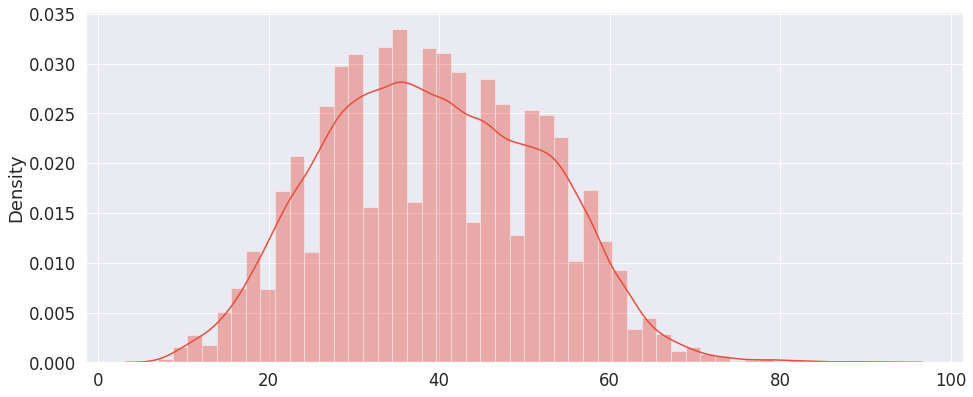

In [19]:
fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [20]:
train= combined[:idx]
test = combined[idx:]
train.shape,test.shape

((54000,), (54000,))

In [21]:
def tokenize_map(sentence,labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    global labels
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 128,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [22]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [23]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

45,900 training samples
8,100 validation samples


In [24]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [25]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [26]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    model_name, # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = len(genre_dict), # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)


Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )
epochs = num_epochs

In [28]:
# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat,average='weighted')

In [30]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
# This training code is based on the `run_glue.py` script here:

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    
    t0 = time.time()

    # Reset the total loss for this epoch.
    
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    
    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    
    model.train()

    # For each batch of training data...
    
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'. 
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
        
        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                            return_dict=False)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        
        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        
        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
        
        optimizer.step()

        # Update the learning rate.
        
        scheduler.step()

    # Calculate the average loss over all of the batches.
    
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    
    model.eval()

    # Tracking variables:
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                  return_dict=False)
            
        # Accumulate the validation loss.
        
        total_eval_loss += loss.item()

        # Move logits and labels to CPU:
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    # Report the final f1 score for this validation run.
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    # Measure how long the validation run took:
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 22 ========
Training...
  Batch    50  of  1,275.    Elapsed: 0:01:08.
  Batch   100  of  1,275.    Elapsed: 0:02:16.
  Batch   150  of  1,275.    Elapsed: 0:03:24.
  Batch   200  of  1,275.    Elapsed: 0:04:31.
  Batch   250  of  1,275.    Elapsed: 0:05:39.
  Batch   300  of  1,275.    Elapsed: 0:06:47.
  Batch   350  of  1,275.    Elapsed: 0:07:54.
  Batch   400  of  1,275.    Elapsed: 0:09:02.
  Batch   450  of  1,275.    Elapsed: 0:10:09.
  Batch   500  of  1,275.    Elapsed: 0:11:17.
  Batch   550  of  1,275.    Elapsed: 0:12:25.
  Batch   600  of  1,275.    Elapsed: 0:13:32.
  Batch   650  of  1,275.    Elapsed: 0:14:40.
  Batch   700  of  1,275.    Elapsed: 0:15:47.
  Batch   750  of  1,275.    Elapsed: 0:16:55.
  Batch   800  of  1,275.    Elapsed: 0:18:03.
  Batch   850  of  1,275.    Elapsed: 0:19:10.
  Batch   900  of  1,275.    Elapsed: 0:20:18.
  Batch   950  of  1,275.    Elapsed: 0:21:25.
  Batch 1,000  of  1,275.    Elapsed: 0:22:33.
  Batch 1,050  o

In [32]:
# Display floats with two decimal places.

pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,1.76,1.62,0.42,0.40,0:28:45,0:01:37
2,1.54,1.61,0.42,0.41,0:28:44,0:01:37
3,1.44,1.63,0.42,0.41,0:28:44,0:01:37
4,1.36,1.66,0.41,0.41,0:28:44,0:01:37
5,1.26,1.71,0.40,0.40,0:28:44,0:01:37
6,1.17,1.78,0.39,0.39,0:28:43,0:01:37
7,1.09,1.86,0.39,0.38,0:28:43,0:01:37
8,1.01,1.96,0.38,0.37,0:28:44,0:01:37
9,0.94,2.06,0.37,0.36,0:28:44,0:01:37


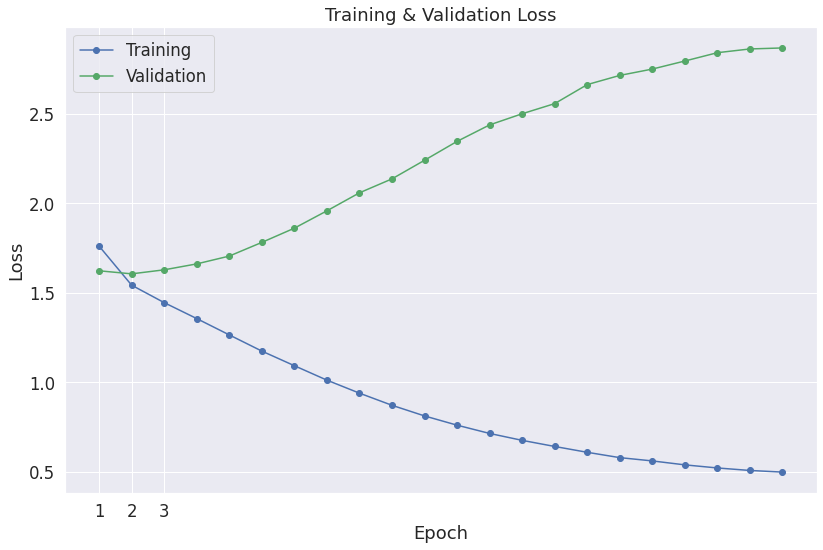

In [33]:
# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [34]:
import torch
from transformers import BertTokenizer, BertModel

# Assuming you have already initialized your BERT model and tokenizer
# model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example code to save the model and tokenizer
def save_bert_model(model, tokenizer, model_path, tokenizer_path):
    # Save the model state dictionary
    torch.save(model.state_dict(), model_path)

    # Save the tokenizer
    tokenizer.save_pretrained(tokenizer_path)

try:
# Example usage
# Save the model and tokenizer
    model_save_path = 'bert_model.pth'
    tokenizer_save_path = 'bert_tokenizer'
    save_bert_model(model, tokenizer, model_save_path, tokenizer_save_path)
except:
    pass


In [35]:
import torch
import time
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

# Assuming you already have the `test_dataloader` set up.

# Define the device for testing (CPU or GPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device.
model.to(device)

# Put the model in evaluation mode.
model.eval()

# Tracking variables for testing.
all_predictions = []  # To store the model's predictions

# Evaluate data for testing.
for batch in prediction_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask).logits
        
    logits = logits.detach().cpu().numpy()
    batch_predictions = logits.argmax(axis=1)  # Get the predicted class index for each sample in the batch
    all_predictions.extend(batch_predictions)



# Assuming you have the test data stored in the DataFrame named `test_df` with columns 'id', 'movie_name', 'synopsis', and 'genre'.
# Create a new DataFrame to store the results.
df2['predicted_genre']=all_predictions

# Map the predicted_genre to the actual genre names using the genre_dict.
df2['genre'] = df2['predicted_genre'].map({v: k for k, v in genre_dict.items()})




In [36]:
df2['id']=pd.read_parquet('./input/movie-genre-prediction/test-00000-of-00001-35e9a9274361daed.parquet')['id']

In [37]:
df2[['id','genre']].to_csv("submission.csv",index=False)